# Bayesian data analysis - PyStan demos
Author: Aki Vehtari, Tuomas Sivula, Co-authors: Lassi Meronen, Pellervo Ruponen

Last modified 2018-Dec.

License: CC-BY

This notebook contains several examples of how to use [Stan](http://mc-stan.org) in python with [PyStan](http://pystan.readthedocs.org). This notebook assumes basic knowledge of Bayesian inference and MCMC. The Stan models are stored in separate .stan-files. The examples are related to Bayesian data analysis course by Aki Vehtari.

## Setting up the PyStan environment

We begin by importing the PyStan module as well at the matplotlib module for basic graphics facilities.

We also import some utilities by Michael Betancourt and introduced in [PyStan workflow case study](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html) in module `stan_utility`.

In [73]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import pystan
import arviz as az # For visualization and loo

In [74]:
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility

In [75]:
# edit default plot settings
plt.rc('font', size=12)
az.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [7.0, 5.4]

## Bernoulli model

Toy data with sequence of failures (0) and successes (1). We would like to learn about the unknown probability of success. In following, we denote this probability with theta.

In [76]:
data = dict(N=10, y=[0,1,0,0,1,1,1,0,1,0])

Bernoulli model with a Beta(1,1) (uniform) prior

In [77]:
with open('bern.stan') as file:
    print(file.read())

// Bernoulli model
data {
  int<lower=0> N;
  int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ bernoulli(theta);
}



Given the Stan program we then use the `compile_model` method of `stan_utility` module to compile the Stan program into a C++ executable. This utility function automatically saves a cached version of the compiled model to the disk for possible future use.

In [78]:
model = stan_utility.compile_model('bern.stan')

Using cached StanModel


Getting the model again with the utility function uses the cached version automatically.

In [79]:
del model
model = stan_utility.compile_model('bern.stan')

Using cached StanModel


Sample from the posterior, show the summary and plot the histogram of the posterior draws. In addition, plot estimated posterior density with arviz posterior plot and 95% credible interval. We recommend explicitly specifying the seed of Stan's random number generator, as we have done here, so that we can reproduce these exactly results in the future, at least when using the same machine, operating system, and interface. This is especially helpful for the more subtle pathologies that may not always be found, which results in seemingly stochastic behavior.

Inference for Stan model: anon_model_4586f2dc76604848221fafe6413762a9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    0.5  3.7e-3   0.14   0.24    0.4    0.5    0.6   0.76   1420    1.0
lp__   -8.84    0.02   0.71 -10.87  -9.04  -8.57  -8.37  -8.32   1690    1.0

Samples were drawn using NUTS at Wed Dec 19 11:19:21 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


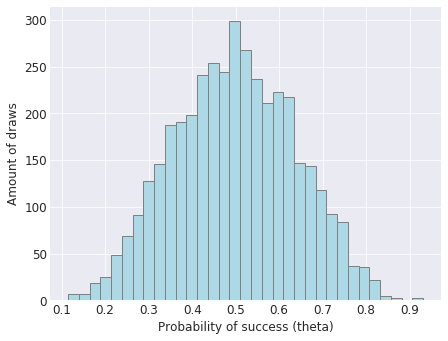

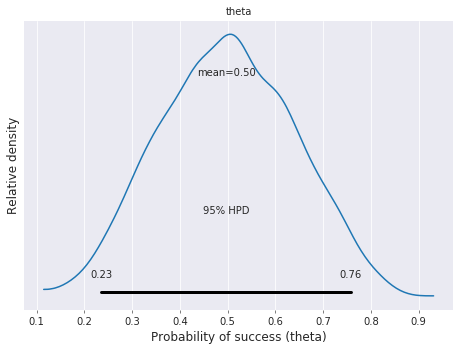

In [80]:
fit = model.sampling(data=data, seed=194838)
print(fit)
samples = fit.extract(permuted=True)

plt.hist(samples['theta'], 33, color='lightblue', edgecolor='grey')
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Amount of draws')

# Plot with arviz plot_posterior.
#    - round_to: sets accuracy of values in plot
az.plot_posterior(fit, var_names=['theta'], credible_interval=0.95, round_to=2)
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Relative density');

## Binomial model

Instead of sequence of 0's and 1's, we can summarize the data with the number of experiments and the number successes:

In [81]:
data = dict(N=10, y=7)

And then we use Binomial model with Beta(1,1) prior for the probability of success.

In [82]:
with open('binom.stan') as file:
    print(file.read())

// Binomial model with beta(1,1,) prior
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ binomial(N,theta);
}



Sample from the posterior and plot the posterior. The histogram should look similar as in the Bernoulli case, except that now the number of successes is 7 instead of 5.

Using cached StanModel


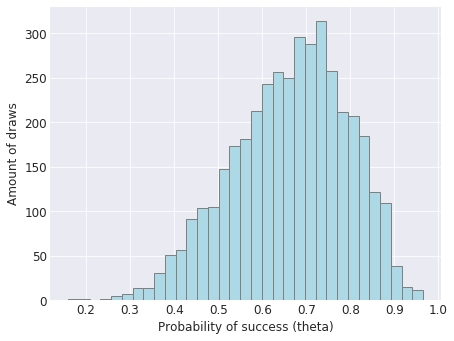

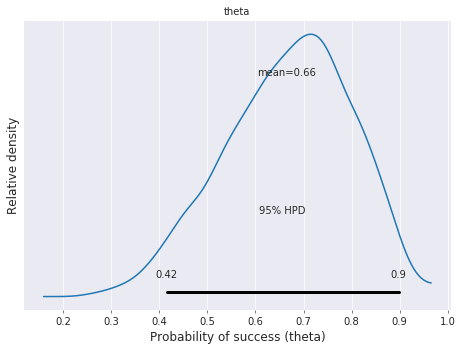

In [83]:
model = stan_utility.compile_model('binom.stan')
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 33, color='lightblue', edgecolor='grey')
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Amount of draws')

az.plot_posterior(fit, var_names=['theta'], credible_interval=0.95, round_to=2)
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Relative density');

Now we re-run the model with a new data (now number of successes being 70 out of 100). The previously compiled Stan program is re-used making the re-use faster.

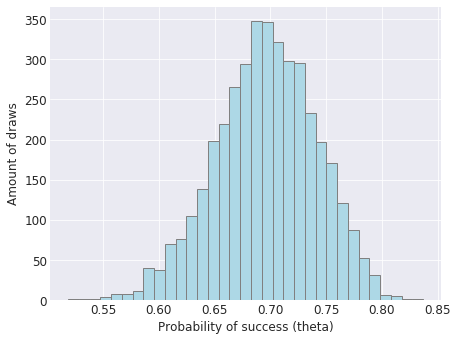

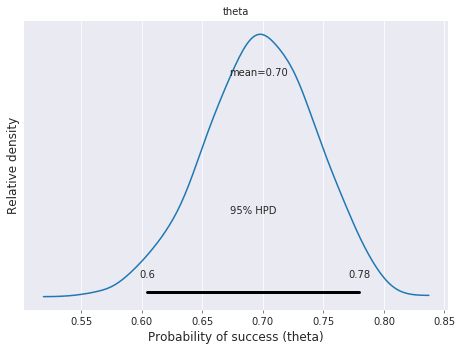

In [84]:
data = dict(N=100, y=70)
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 33, color='lightblue', edgecolor='grey') # histogram
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Amount of draws')

az.plot_posterior(fit, var_names=['theta'], credible_interval=0.95, round_to=2)
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Relative density');

## Explicit transformation of variables
In the above examples the probability of success θ was declared as:

real<lower=0,upper=1> theta;

Stan makes automatic transformation of the variable to the unconstrained space using logit transofrmation for interval constrained and log transformation for half constraints.

The following example shows how we can also make an explicit transformation and use binomial_logit function which takes the unconstrained parameter as an argument and uses logit transformation internally. This form can be useful for better numerical stability.

In [85]:
with open('binomb.stan') as file:
    print(file.read())

// Binomial model with a roughly uniform prior for
// the probability of success (theta)
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real alpha;
}
transformed parameters {
  real theta;
  theta = inv_logit(alpha);
}
model {
  // roughly auniform prior for the number of successes
  alpha ~ normal(0,1.5);
  y ~ binomial_logit(N,alpha);
}



In [86]:
model = stan_utility.compile_model('binomb.stan')

Using cached StanModel


Here we have used Gaussian prior in the unconstrained space, which produces close to uniform prior for theta. 

Sample from the posterior and plot the posterior. The histogram should look similar as with the previous model

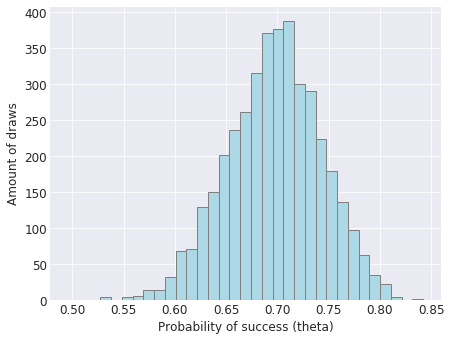

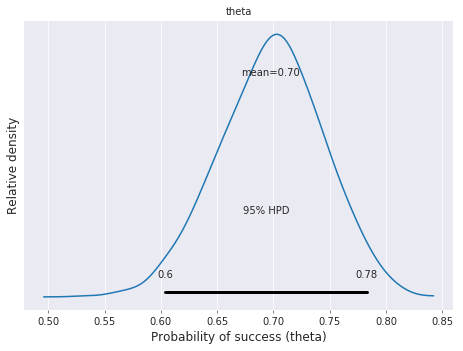

In [87]:
data = dict(N=100, y=70)
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 33, color='lightblue', edgecolor='grey')
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Amount of draws')

az.plot_posterior(fit, var_names=['theta'], credible_interval=0.95, round_to=2)
plt.xlabel(r'Probability of success (theta)')
plt.ylabel('Relative density');

## Comparison of two groups with Binomial

An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients. A group of patients were randomly assigned to treatment and control groups:

- out of 674 patients receiving the control, 39 died
- out of 680 receiving the treatment, 22 died

Data:

In [88]:
data = dict(N1=674, y1=39, N2=680, y2=22)

To analyse whether the treatment is useful, we can use Binomial model for both groups and compute odds-ratio. If the odds-ratio is less than 1, it means that the treatment is useful.

In [89]:
with open('binom2.stan') as file:
    print(file.read())

//  Comparison of two groups with Binomial
data {
  int<lower=0> N1;
  int<lower=0> y1;
  int<lower=0> N2;
  int<lower=0> y2;
}
parameters {
  real<lower=0,upper=1> theta1;
  real<lower=0,upper=1> theta2;
}
model {
  theta1 ~ beta(1,1);
  theta2 ~ beta(1,1);
  y1 ~ binomial(N1,theta1);
  y2 ~ binomial(N2,theta2);
}
generated quantities {
  real oddsratio;
  oddsratio = (theta2/(1-theta2))/(theta1/(1-theta1));
}



Sample from the posterior and plot the posterior for the odds-ratio. We plot the posterior both as a histogram and and as an estimated probability density function. Using ArviZ, we can easily see the probability of the odds-ratio being less than 1.

Using cached StanModel


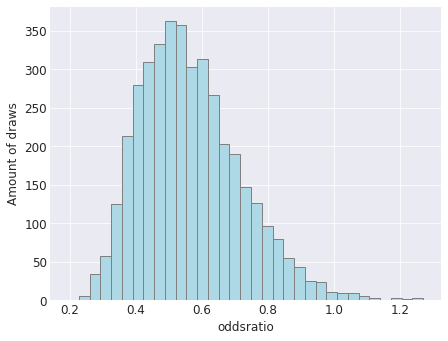

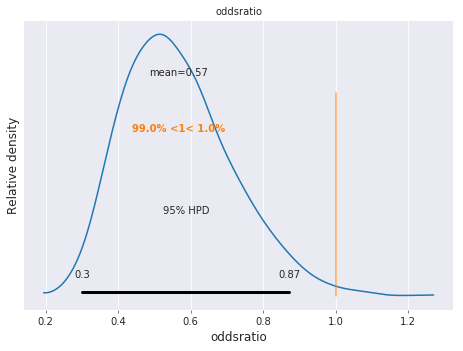

In [90]:
model = stan_utility.compile_model('binom2.stan')
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)
plt.hist(samples['oddsratio'], 33, color='lightblue', edgecolor='grey')
plt.xlabel('oddsratio')
plt.ylabel('Amount of draws')

# With az.plot_posterior we use parameter ref_val = 1
# since treatment is beneficial if oddsratio is smaller than 1.
az.plot_posterior(fit, var_names=['oddsratio'], credible_interval=0.95, round_to=2, ref_val=1)
plt.xlabel('oddsratio')
plt.ylabel('Relative density')
plt.savefig('odd-ratio.pdf')

## Linear Gaussian model

The following file has Kilpisjärvi summer month temperatures 1952-2013:

In [91]:
data_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'kilpisjarvi-summer-temp.csv'
    )
)
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
x = d[:, 0]
y = d[:, 4]
N = len(x)
xpred = 2016

Plot the data

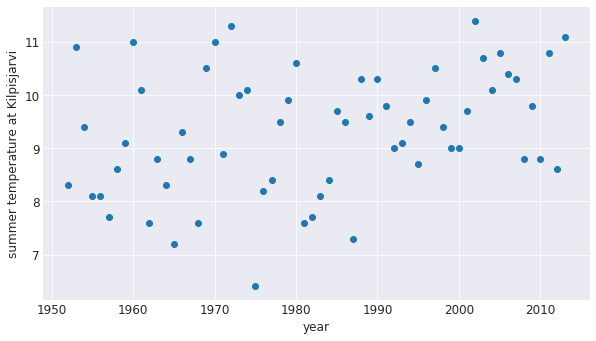

In [92]:
# make slightly wider figure
wide_figsize = plt.rcParams['figure.figsize'].copy()
wide_figsize[0] *= 1.4
plt.figure(figsize=wide_figsize)
plt.scatter(x, y)
plt.xlabel('year')
plt.ylabel('summer temperature at Kilpisjarvi');

To analyse whether the average summer month temperature is rising, we use a linear model with Gaussian model for the unexplained variation. 

### Gaussian linear model with adjustable priors

The following Stan code allows also setting hyperparameter values as data allowing easier way to use different priors in different analyses:

In [93]:
with open('lin.stan') as file:
    print(file.read())

// Gaussian linear model with adjustable priors
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
  real pmualpha; // prior mean for alpha
  real psalpha;  // prior std for alpha
  real pmubeta;  // prior mean for beta
  real psbeta;   // prior std for beta
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  alpha ~ normal(pmualpha, psalpha);
  beta ~ normal(pmubeta, psbeta);
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}



Create a list with data and priors:

In [94]:
data = dict(
    N = N,
    x = x,
    y = y,
    xpred = xpred,
    pmualpha = y.mean(),     # centered
    psalpha  = 100,          # weakly informative prior
    pmubeta  = 0,            # a priori increase and decrese as likely
    psbeta   = (.1--.1)/6.0  # avg temp probably does not increase more than 1
                             # degree per 10 years
)

Run Stan

In [95]:
model = stan_utility.compile_model('lin.stan')
fit_lin = model.sampling(data=data, seed=194838)
samples = fit_lin.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [96]:
print(fit_lin)

Inference for Stan model: anon_model_6d95d5cbf9b9fb7d99a793b066a7bb72.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -28.09    0.47  16.09 -59.57  -39.0 -27.89  -17.1   3.04   1172    1.0
beta          0.02  2.4e-4 8.1e-3 3.2e-3   0.01   0.02   0.02   0.03   1172    1.0
sigma         1.13  3.0e-3   0.11   0.94   1.05   1.13    1.2   1.38   1452    1.0
mu[1]         8.74  7.7e-3   0.29   8.17   8.54   8.74   8.93    9.3   1417    1.0
mu[2]         8.75  7.4e-3   0.28   8.21   8.56   8.76   8.95    9.3   1432    1.0
mu[3]         8.77  7.2e-3   0.27   8.24   8.58   8.77   8.96   9.31   1448    1.0
mu[4]         8.79  7.0e-3   0.27   8.27   8.61   8.79   8.97   9.31   1466    1.0
mu[5]         8.81  6.8e-3   0.26   8.31   8.63   8.81   8.99   9.32   1485    1.0
mu[6]         8.83  6.6e-3   0.25   8.34   8.66   8.83    9.0   

Check the treedepth, E-BFMI, and divergences

In [97]:
stan_utility.check_treedepth(fit_lin)
stan_utility.check_energy(fit_lin)
stan_utility.check_div(fit_lin)

178 of 4000 iterations saturated the maximum tree depth of 10 (4.45%)
Run again with max_depth set to a larger value to avoid saturation
0.0 of 4000 iterations ended with a divergence (0.0%)


We get a warning that several iterations saturated the maximum treedepth. The reason for this is a very strong posterior correlation between alpha and beta as shown in the next plot. This doesn't invalidate the results, but leads to suboptimal performance. We'll later look at alternative which reduces the posterior correlation. The following figure shows the strong posterior correlation in the current case.

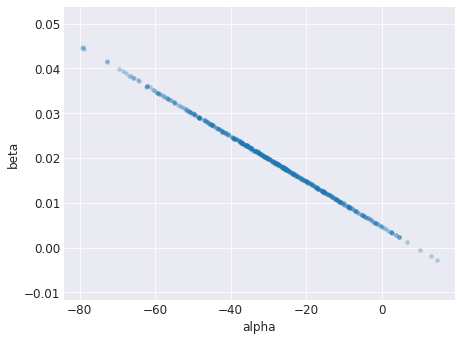

In [98]:
samples = fit_lin.extract(permuted=True)
# preview 500 posterior samples of (alpha, beta)
plt.scatter(samples['alpha'][:500], samples['beta'][:500], 50, marker='.', alpha=0.25)
plt.xlabel('alpha')
plt.ylabel('beta');

Compute the probability that the summer temperature is increasing. The beta-parameter represents the slope of the temperature change. Hence, by checking the probability that beta > 0, we get the probability that the temperature is rising.

In [99]:
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

Pr(beta > 0) = 0.9895


Plot the data, the model fit and prediction for year 2016.

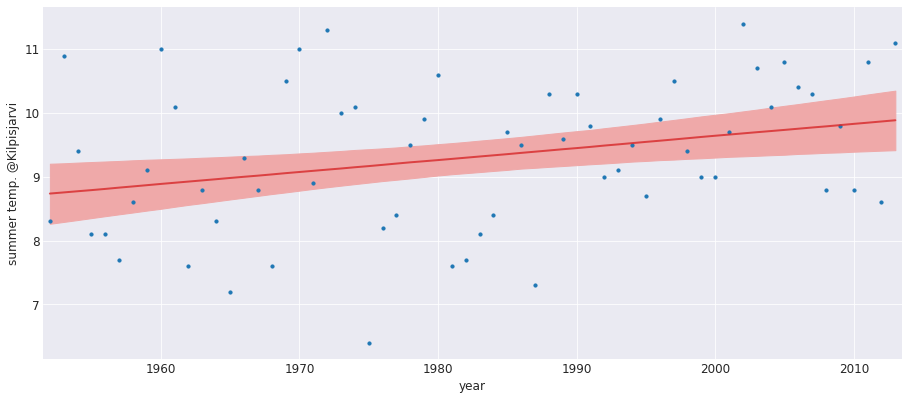

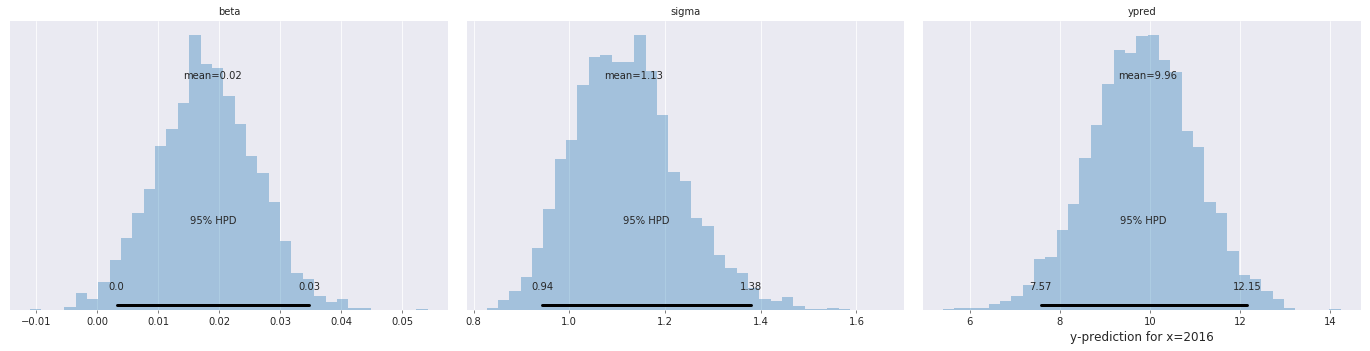

In [100]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2.2  # width
figsize[1] *= 1.2  # width
fig, ax = plt.subplots(1, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C3'     # 'C1' for default color #1

ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    # lighten color_line
    color=1 - 0.4*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=2,
    alpha=0.8
)
ax.scatter(x, y, 10, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('summer temp. @Kilpisjarvi')
ax.set_xlim((1951.5, 2013.5))


az.plot_posterior(fit_lin, var_names=['beta','sigma','ypred'], credible_interval=0.95, round_to=2, kind='hist', bins=35)
plt.xlabel('y-prediction for x={}'.format(xpred));

For the beta parameter (the slope), let's also plot the relative density with reference value of 0. Now we can easily evaluate the probability for slope being positive.

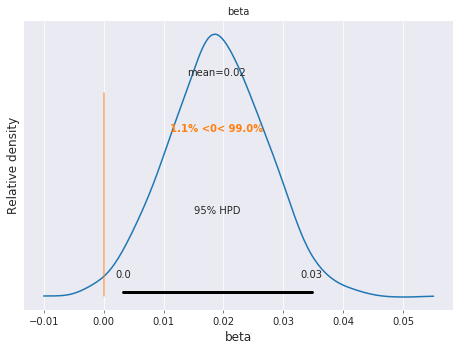

In [101]:
az.plot_posterior(fit_lin, var_names=['beta'], credible_interval=0.95, round_to=2, ref_val=0, kind='kde')
plt.xlabel('beta')
plt.ylabel('Relative density');

### Gaussian linear model with standardized data

In the above we used the unnormalized data and as x values are far away from zero, this will cause very strong posterior dependency between alpha and beta. The strong posterior dependency can be removed by normalizing the data to have zero mean. The following Stan code makes it in Stan. In generated quantities we do correspnding transformation back to the original scale.

In [102]:
with open('lin_std.stan') as file:
    print(file.read())

// Gaussian linear model with standardized data
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
}
transformed data {
  vector[N] x_std;
  vector[N] y_std;
  real xpred_std;
  x_std = (x - mean(x)) / sd(x);
  y_std = (y - mean(y)) / sd(y);
  xpred_std = (xpred - mean(x)) / sd(x);
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma_std;
}
transformed parameters {
  vector[N] mu_std;
  mu_std = alpha + beta*x_std;
}
model {
  alpha ~ normal(0, 1);
  beta ~ normal(0, 1);
  y_std ~ normal(mu_std, sigma_std);
}
generated quantities {
  vector[N] mu;
  real<lower=0> sigma;
  real ypred;
  vector[N] log_lik;
  mu = mu_std*sd(y) + mean(y);
  sigma = sigma_std*sd(y);
  ypred = normal_rng((alpha + beta*xpred_std)*sd(y)+mean(y), sigma*sd(y));
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[i], sigma);
}



Run Stan

In [103]:
model = stan_utility.compile_model('lin_std.stan')
fit_lin_std = model.sampling(data=data, seed=194838)
samples = fit_lin_std.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [104]:
print(fit_lin_std)

Inference for Stan model: anon_model_161eb30961f09398a0825482beb4b070.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       6.7e-4  2.0e-3   0.12  -0.25  -0.08 1.2e-3   0.08   0.26   3733    1.0
beta          0.31  1.9e-3   0.12   0.06   0.23   0.31   0.39   0.55   3988    1.0
sigma_std     0.98  1.6e-3   0.09   0.82   0.91   0.97   1.03   1.18   3457    1.0
mu_std[1]    -0.52  3.7e-3   0.24  -0.99  -0.68  -0.53  -0.37  -0.04   4221    1.0
mu_std[2]    -0.51  3.6e-3   0.23  -0.96  -0.66  -0.51  -0.36  -0.03   4222    1.0
mu_std[3]    -0.49  3.5e-3   0.23  -0.93  -0.64  -0.49  -0.34  -0.03   4220    1.0
mu_std[4]    -0.47  3.4e-3   0.22  -0.91  -0.62  -0.48  -0.33  -0.02   4216    1.0
mu_std[5]    -0.45  3.3e-3   0.22  -0.88   -0.6  -0.46  -0.32  -0.02   4213    1.0
mu_std[6]    -0.44  3.2e-3   0.21  -0.85  -0.58  -0.44   -0.3-8.

We get now much better effective sample sizes `n_eff`.

Check the treedepth, E-BFMI, and divergences

In [105]:
stan_utility.check_treedepth(fit_lin_std)
stan_utility.check_energy(fit_lin_std)
stan_utility.check_div(fit_lin_std)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


Everything is fine now. The next figure shows that with the standardized data there is not much posterior correlation:

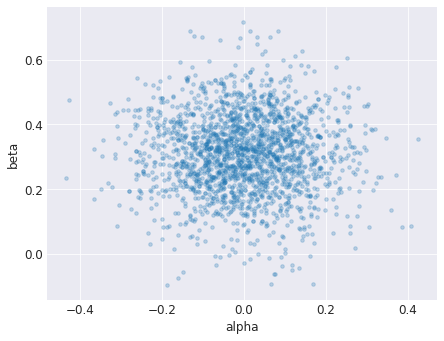

In [106]:
samples = fit_lin_std.extract(permuted=True)
plt.figure()
# preview 2000 samples
plt.scatter(samples['alpha'][:2000], samples['beta'][:2000], 50, marker='.', alpha=0.25)
plt.xlabel('alpha')
plt.ylabel('beta');

Compute the probability that the summer temperature is increasing.

In [107]:
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

Pr(beta > 0) = 0.991


Plot the data, the model fit and prediction for year 2016.

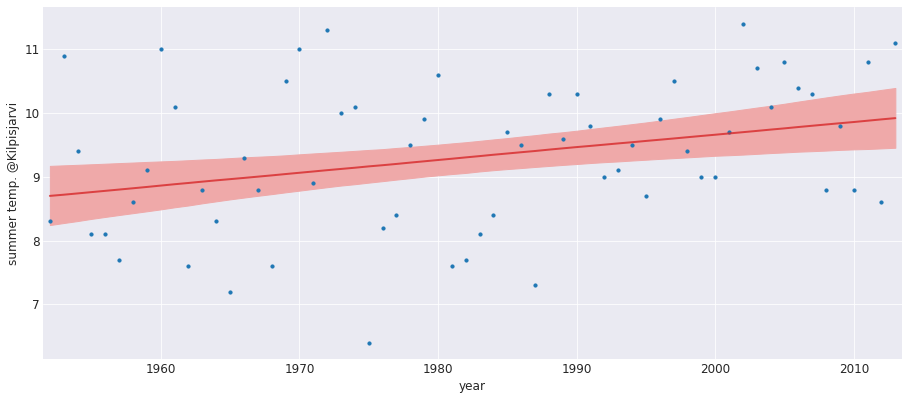

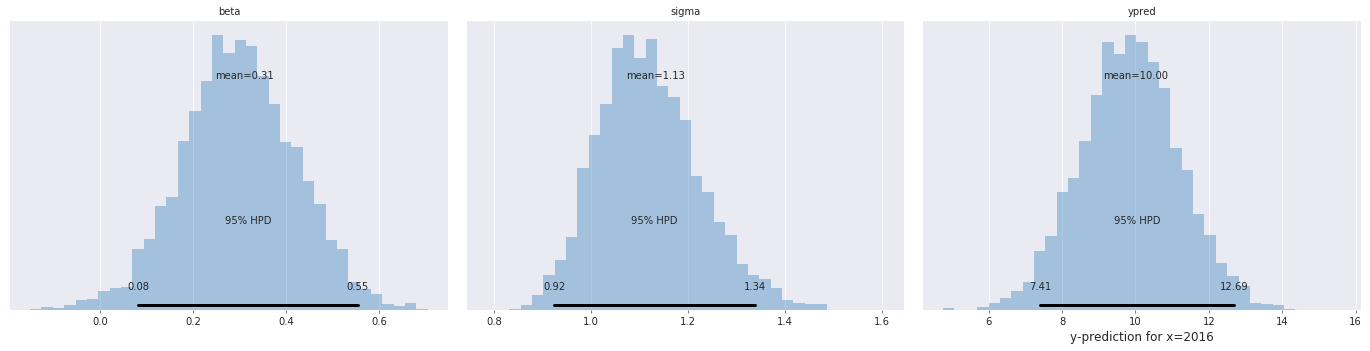

In [108]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2.2  # width
figsize[1] *= 1.2  # width
fig, ax = plt.subplots(1, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C3'     # 'C1' for default color #1

ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    # lighten color_line
    color=1 - 0.4*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=2,
    alpha=0.8
)
ax.scatter(x, y, 10, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('summer temp. @Kilpisjarvi')
ax.set_xlim((1951.5, 2013.5))

az.plot_posterior(fit_lin_std, var_names=['beta','sigma','ypred'], credible_interval=0.95, round_to=2, kind='hist', bins=35)
plt.xlabel('y-prediction for x={}'.format(xpred));

Now we can also plot ridgeplot for mu samples. Ridge plot better illustrates the fact that each year is represented by distribution for mu parameter.

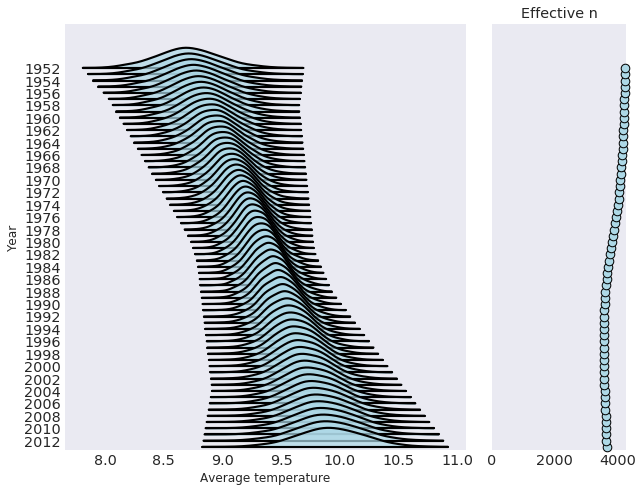

In [109]:
# Make complementary ridge plot
fig, axes = az.plot_forest(fit_lin_std,
                           kind='ridgeplot',
                           var_names=['mu'],
                           combined=True,
                           r_hat = False,
                           n_eff = True,
                           ridgeplot_overlap=5,
                           ridgeplot_alpha=0.7,
                           colors='lightblue',
                           figsize=(9, 7))
# Let's adjust labels (default arviz labels are not so good for large amount of distributions)
axes[0].set_yticklabels(
    [str(year) if year % 2 == 0 else '' for year in range(2013, 1952-1, -1)])
axes[0].set_ylabel('Year')
axes[0].set_xlabel('Average temperature')
# make figure compact
fig.tight_layout();

## Linear Student's t model.

The temperatures used in the above analyses are averages over three months, which makes it more likely that they are normally distributed, but there can be extreme events in the weather and we can check whether more robust Student's t observation model would give different results. For the Student's t distribution we also need the degree of freedom, nu, as an additional parameter.

In [110]:
with open('lin_t.stan') as file:
    print(file.read())

// Linear student-t model
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
  real<lower=1, upper=80> nu;
}
transformed parameters {
  vector[N] mu;
  mu = alpha + beta*x;
}
model {
  nu ~ gamma(2, 0.1); // Juarez and Steel(2010)
  y ~ student_t(nu, mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(alpha + beta*xpred, sigma);
  for (i in 1:N)
    log_lik[i] = student_t_lpdf(y[i] | nu, mu[i], sigma);
}



In [111]:
model = stan_utility.compile_model('lin_t.stan')
fit_lin_t = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat`

In [112]:
print(fit_lin_t)

Inference for Stan model: anon_model_985e43a8fe28088e3317d00edd324bab.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       -32.55    0.44  16.05 -64.15 -43.72 -32.53  -21.6  -0.96   1343    1.0
beta          0.02  2.2e-4 8.1e-3 5.2e-3   0.02   0.02   0.03   0.04   1342    1.0
sigma         1.08  2.6e-3   0.11   0.88    1.0   1.08   1.15   1.32   1827    1.0
nu           23.97    0.33  13.37   5.72  14.18   21.2  30.96  57.83   1670    1.0
mu[1]         8.67  7.1e-3   0.29   8.11   8.47   8.66   8.87   9.24   1684    1.0
mu[2]         8.69  6.9e-3   0.28   8.14    8.5   8.69   8.89   9.25   1701    1.0
mu[3]         8.71  6.6e-3   0.28   8.18   8.53   8.71    8.9   9.25   1721    1.0
mu[4]         8.73  6.4e-3   0.27   8.21   8.55   8.73   8.92   9.26   1742    1.0
mu[5]         8.75  6.2e-3   0.26   8.25   8.58   8.75   8.94   

Again without standardization we get smaller n_eff's, but large enough for practical purposes.

Check the treedepth, E-BFMI, and divergences

In [113]:
stan_utility.check_treedepth(fit_lin_t)
stan_utility.check_energy(fit_lin_t)
stan_utility.check_div(fit_lin_t)

108 of 4000 iterations saturated the maximum tree depth of 10 (2.7%)
Run again with max_depth set to a larger value to avoid saturation
0.0 of 4000 iterations ended with a divergence (0.0%)


We see again many iterations saturating the maximum tree depth, which is harmful for the efficiency but doesn't invalidate the results.

Compute the probability that the summer temperature is increasing.

In [114]:
samples = fit_lin_t.extract(permuted=True)
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

Pr(beta > 0) = 0.9965


We get similar probability as with Gaussian obervation model.

Plot the data, the model fit, and the marginal posteriors for sigma and nu.

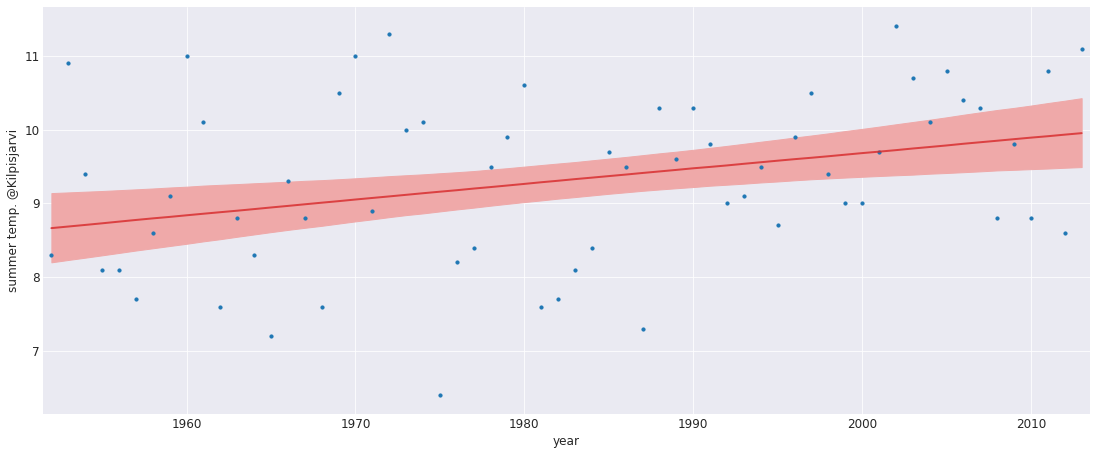

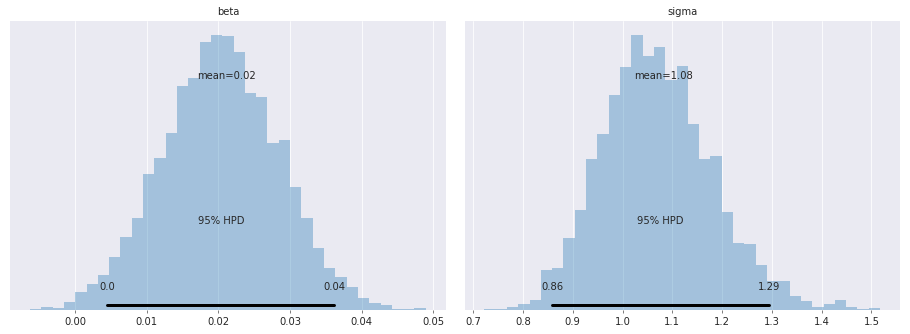

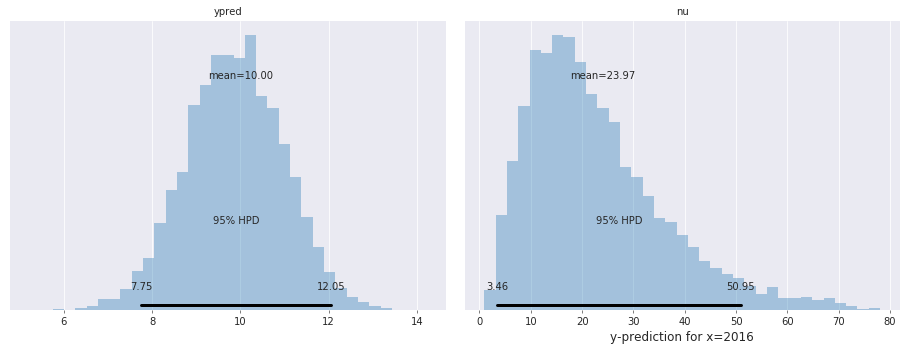

In [115]:
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2.2  # width
figsize[1] *= 1.2  # width
fig, ax = plt.subplots(1, 1, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C3'     # 'C1' for default color #1

ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    # lighten color_line
    color=1 - 0.4*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=2,
    alpha=0.8
)
ax.scatter(x, y, 10, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('summer temp. @Kilpisjarvi')
ax.set_xlim((1951.5, 2013.5))

az.plot_posterior(fit_lin_t, var_names=['beta','sigma'], credible_interval=0.95, round_to=2, kind='hist', bins=35)
az.plot_posterior(fit_lin_t, var_names=['ypred', 'nu'], credible_interval=0.95, round_to=2, kind='hist', bins=35)

plt.xlabel('y-prediction for x={}'.format(xpred));
# make figure compact
fig.tight_layout();

The posterior of the degree of freedom "nu" reveals that Gaussian model is likely to be ok, as Student's t with `nu > 20` is very close to Gaussian.

# Pareto-smoothed importance-sampling leave-one-out cross-validation (PSIS-LOO)
We can use leave-one-out cross-validation to compare the expected predictive performance. For the following three lines to execute, the log-likelihood needs to be evaluated in the stan code. For an example, see:
- stan file lin.stan 
- [ArviZ API](https://arviz-devs.github.io/arviz/api.html) (for Python) 
- [Computing approximate leave-one-out cross-validation usig PSIS-LOO](http://mc-stan.org/loo/articles/loo2-with-rstan.html) (In R). 

In [131]:
# Convert stan objects to ArviZ inference data objects
inference_lin = az.convert_to_inference_data(fit_lin, log_likelihood='log_lik')
inference_lin_t = az.convert_to_inference_data(fit_lin_t, log_likelihood='log_lik')

# Store inference data objects to dictionary
models = dict([
         ("linear_model", inference_lin),
         ("linear_model_t", inference_lin_t)
             ])

# Compare models with loo
comparison = az.compare(models, ic='loo')
print(comparison)

                    loo     ploo      dloo weight       se       dse warning
linear_model    192.957  2.80436         0      1  10.0009         0       0
linear_model_t  193.434   2.7311  0.477703      0  10.1958  0.847232       0


Loo values are similar for models. Hence, there is no practical difference between Gaussian and Student’s t observation model for this data.



# Comparison of k groups with hierarchical models

In following, for each year, we analyze the monthly average temperatures for three summer months: June, July and August. In previous example, we used the average of these three summer months as estimate for yearly average summer temperarute. Now we would like to know, if there is a difference between three summer months: June, July and August.

In [117]:
data_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'kilpisjarvi-summer-temp.csv'
    )
)
# Load data
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
# summer months are numbered from 1 to 3
x = np.tile(np.arange(1, 4), d.shape[0]) # create array with repeating numbers 1,2,3 for each year
y = d[:, 1:4].ravel()
N = len(x)
data = dict(
    N = N,
    K = 3,  # 3 groups
    x = x,  # group indicators
    y = y)  # observations

## Common variance (ANOVA) model

In [118]:
with open('grp_aov.stan') as file:
    print(file.read())

// Comparison of k groups with common variance (ANOVA)
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  vector[K] mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu[x], sigma);
}



Fit the model

In [119]:
model = stan_utility.compile_model('grp_aov.stan')
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)

Using cached StanModel


Check the `n_eff` and `Rhat` values for sampled model.

In [120]:
print(fit)

Inference for Stan model: anon_model_7564a28d1f0313ff396284979a4361d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]   7.54  2.9e-3    0.2   7.15   7.41   7.54   7.67   7.92   4644    1.0
mu[2]  10.97  2.9e-3    0.2  10.58  10.83  10.97   11.1  11.35   4738    1.0
mu[3]   9.44  2.7e-3   0.19   9.06    9.3   9.43   9.57   9.82   4937    1.0
sigma   1.53  1.2e-3   0.08   1.38   1.47   1.53   1.58    1.7   4344    1.0
lp__  -170.9    0.03    1.4 -174.3 -171.6 -170.5 -169.8 -169.1   1957    1.0

Samples were drawn using NUTS at Wed Dec 19 11:20:18 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Check the treedepth, E-BFMI, and divergences

In [121]:
stan_utility.check_treedepth(fit)
stan_utility.check_energy(fit)
stan_utility.check_div(fit)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


Plot group mean distributions and matrix of probabilities that one mu is larger than other.

Matrix of probabilities that one mu is larger than other:
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]


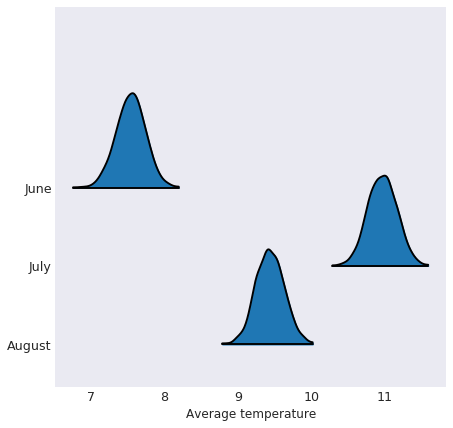

In [122]:
# matrix of probabilities that one mu is larger than other
mu = fit.extract(permuted=True)['mu']
ps = np.zeros((3, 3))
for k1 in range(3):
    for k2 in range(k1+1, 3):
        ps[k1, k2] = np.mean(mu[:, k1] > mu[:, k2])
        ps[k2, k1] = 1 - ps[k1, k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)

months = ['June', 'July', 'August']
fig, ax = az.plot_forest(fit,
                           kind='ridgeplot',
                           var_names=['mu'],
                           combined=True,
                           ridgeplot_overlap=1,
                           r_hat=False,
                           n_eff=False,
                           figsize=(7, 7))
ax[0].set_yticklabels(months[::-1]) # Order of months if reversed, since arviz flips the order of ticks in plot
ax[0].set_xlabel('Average temperature');

## Common variance and hierarchical prior for mean.

Results do not differ much from the previous, because there is only
few groups and quite much data per group, but this works as an example of a hierarchical model.


In [123]:
with open('grp_prior_mean.stan') as file:
    print(file.read())

// Comparison of k groups with common variance and
// hierarchical prior for the mean
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}
parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
  mu0 ~ normal(10,10);      // weakly informative prior
  sigma0 ~ cauchy(0,4);     // weakly informative prior
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  sigma ~ cauchy(0,4);      // weakly informative prior
  y ~ normal(mu[x], sigma);
}



Fit the model

In [124]:
model = stan_utility.compile_model('grp_prior_mean.stan')
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)

Using cached StanModel


Plot group mean distributions and matrix of probabilities that one mu is larger than other. The probabilities are practically either 1 or 0 since the distributions are not overlapping almost at all. This can be visually seen from ridge plot below.

Matrix of probabilities that one mu is larger than other:
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]


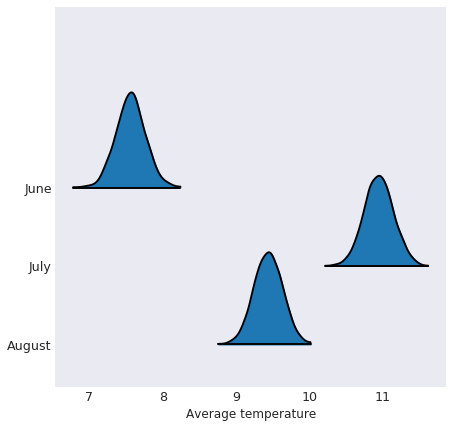

In [125]:
# matrix of probabilities that one mu is larger than other
mu = fit.extract(permuted=True)['mu']
ps = np.zeros((3, 3))
for k1 in range(3):
    for k2 in range(k1+1, 3):
        ps[k1, k2] = np.mean(mu[:, k1] > mu[:, k2])
        ps[k2, k1] = 1 - ps[k1, k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)

months = ['June', 'July', 'August']
fig, ax = az.plot_forest(fit,
                           kind='ridgeplot',
                           var_names=['mu'],
                           combined=True,
                           ridgeplot_overlap=1,
                           r_hat=False,
                           n_eff=False,
                           figsize=(7, 7))
ax[0].set_yticklabels(months[::-1])
ax[0].set_xlabel('Average temperature');

## Unequal variance and hierarchical prior for mean and variance

Results do not differ much from the previous, because there is only
few groups and quite much data per group, but this works as an example of a hierarchical model.

In [126]:
with open('grp_prior_mean_var.stan') as file:
    print(file.read())

// Comparison of k groups with unequal variance and
// hierarchical priors for the mean and the variance
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
}
parameters {
  real mu0;                 // prior mean
  real<lower=0> musigma0;   // prior std
  vector[K] mu;             // group means
  real lsigma0;             // prior mean
  real<lower=0> lsigma0s;   // prior std
  vector<lower=0>[K] sigma; // group stds
}
model {
  mu0 ~ normal(10, 10);       // weakly informative prior
  musigma0 ~ cauchy(0,10);    // weakly informative prior
  mu ~ normal(mu0, musigma0); // population prior with unknown parameters
  lsigma0 ~ normal(0,1);      // weakly informative prior
  lsigma0s ~ normal(0,1);     // weakly informative prior
  sigma ~ cauchy(lsigma0, lsigma0s); // population prior with unknown parameters
  y ~ normal(mu[x], sigma[x]);
}



Fit the model

In [127]:
model = stan_utility.compile_model('grp_prior_mean_var.stan')
fit = model.sampling(data=data, seed=194838)
samples = fit.extract(permuted=True)

Using cached StanModel


Plot group mean distributions and matrix of probabilities that one mu is larger than other:

std(mu0): 2.55
Matrix of probabilities that one mu is larger than other:
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]


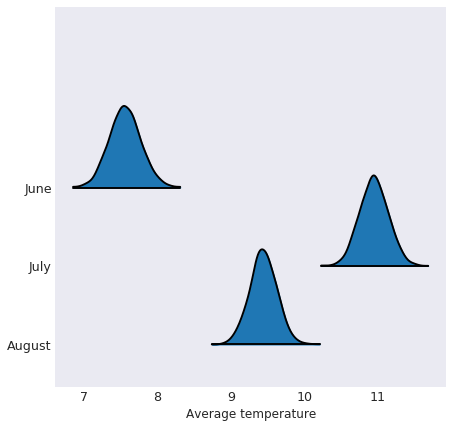

In [128]:
samples = fit.extract(permuted=True)
print("std(mu0): {:.2f}".format(np.std(samples['mu0'])))
mu = samples['mu']

# matrix of probabilities that one mu is larger than other
ps = np.zeros((3, 3))
for k1 in range(3):
    for k2 in range(k1+1, 3):
        ps[k1, k2] = np.mean(mu[:, k1] > mu[:, k2])
        ps[k2, k1] = 1 - ps[k1, k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)

months = ['June', 'July', 'August']
fig, ax = az.plot_forest(fit,
                           kind='ridgeplot',
                           var_names=['mu'],
                           combined=True,
                           ridgeplot_overlap=1,
                           r_hat=False,
                           n_eff=False,
                           figsize=(7, 7))
ax[0].set_yticklabels(months[::-1])
ax[0].set_xlabel('Average temperature');